<a href="https://www.kaggle.com/code/vnniciusgabriel/survival-analysis-keplan-meier?scriptVersionId=229103379" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 7.1 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=44960c07d7721d747f27650973dff893ed86f2dd9d4b30a09c95d14d6c06d8dc
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test


__import__('warnings').filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/breast-cancer-survival-dataset/breast_cancer_survival.csv


In [3]:
df = pd.read_csv('/kaggle/input/breast-cancer-survival-dataset/breast_cancer_survival.csv',
                parse_dates=['Date_of_Surgery', 'Date_of_Last_Visit'])
df.head()

,Age,Gender,Protein1,Protein2,Protein3,Protein4,Tumour_Stage,Histology,ER status,PR status,HER2 status,Surgery_type,Date_of_Surgery,Date_of_Last_Visit,Patient_Status
0,42,FEMALE,0.95256,2.15000,0.007972,-0.048340,II,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Other,2018-05-20,2018-08-26,Alive
1,54,FEMALE,0.00000,1.38020,-0.498030,-0.507320,II,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Other,2018-04-26,2019-01-25,Dead
2,63,FEMALE,-0.52303,1.76400,-0.370190,0.010815,II,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Lumpectomy,2018-08-24,2020-04-08,Alive
3,78,FEMALE,-0.87618,0.12943,-0.370380,0.132190,I,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Other,2018-11-16,2020-07-28,Alive
4,42,FEMALE,0.22611,1.74910,-0.543970,-0.390210,II,Infiltrating Ductal Carcinoma,Positive,Positive,Positive,Lumpectomy,2018-12-12,2019-01-05,Alive


# Exploratory Data Analysis (EDA)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334 entries, 0 to 333
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Age                 334 non-null    int64         
 1   Gender              334 non-null    object        
 2   Protein1            334 non-null    float64       
 3   Protein2            334 non-null    float64       
 4   Protein3            334 non-null    float64       
 5   Protein4            334 non-null    float64       
 6   Tumour_Stage        334 non-null    object        
 7   Histology           334 non-null    object        
 8   ER status           334 non-null    object        
 9   PR status           334 non-null    object        
 10  HER2 status         334 non-null    object        
 11  Surgery_type        334 non-null    object        
 12  Date_of_Surgery     334 non-null    datetime64[ns]
 13  Date_of_Last_Visit  317 non-null    datetime64[ns]

In [5]:
df.describe(include='all')

,Age,Gender,Protein1,Protein2,Protein3,Protein4,Tumour_Stage,Histology,ER status,PR status,HER2 status,Surgery_type,Date_of_Surgery,Date_of_Last_Visit,Patient_Status
count,334.000000,334,334.000000,334.000000,334.000000,334.000000,334,334,334,334,334,334,334,317,321
unique,NaN,2,NaN,NaN,NaN,NaN,3,3,1,1,2,4,NaN,NaN,2
top,NaN,FEMALE,NaN,NaN,NaN,NaN,II,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Other,NaN,NaN,Alive
freq,NaN,330,NaN,NaN,NaN,NaN,189,233,334,334,305,105,NaN,NaN,255
mean,58.886228,NaN,-0.029991,0.946896,-0.090204,0.009819,NaN,NaN,NaN,NaN,NaN,NaN,2018-09-08 00:38:48.143712512,2019-11-26 02:34:26.876971520,NaN
min,29.000000,NaN,-2.340900,-0.978730,-1.627400,-2.025500,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-15 00:00:00,2017-04-05 00:00:00,NaN
25%,49.000000,NaN,-0.358888,0.362173,-0.513748,-0.377090,NaN,NaN,NaN,NaN,NaN,NaN,2018-03-11 00:00:00,2019-01-29 00:00:00,NaN
50%,58.000000,NaN,0.006129,0.992805,-0.173180,0.041768,NaN,NaN,NaN,NaN,NaN,NaN,2018-10-05 00:00:00,2019-12-28 00:00:00,NaN
75%,68.000000,NaN,0.343598,1.627900,0.278353,0.425630,NaN,NaN,NaN,NaN,NaN,NaN,2019-04-04 00:00:00,2020-08-27 00:00:00,NaN
max,90.000000,NaN,1.593600,3.402200,2.193400,1.629900,NaN,NaN,NaN,NaN,NaN,NaN,2019-11-21 00:00:00,2026-09-24 00:00:00,NaN


## **Key observations:**

* 330 rows, 15 columns
* missing values in Date_of_Last_Visit (censored patients)
* all **ER status** and **PR status** values are 'Positive'

In [6]:
df['Survival_Time'] = (df['Date_of_Last_Visit'] - df['Date_of_Surgery']).dt.days

In [7]:
df['Event'] = df['Patient_Status'].map({'Alive': 0, 'Dead': 1})

## Handle Missing Values & Survival Time Calculation

In [8]:
df = df.dropna(subset='Patient_Status')

study_end_date = pd.to_datetime('31/12/2023')
df['Date_of_Last_Visit'] = df['Date_of_Last_Visit'].fillna(study_end_date)

df['Survival_Time'] = (df['Date_of_Last_Visit'] - df['Date_of_Surgery']).dt.days
df['Event_Observed'] = df['Patient_Status'].map({'Dead': 1, 'Alive': 0})

## Descriptive Statistics

### Continuos Variable

In [9]:
df[['Age', 'Protein1', 'Protein2', 'Protein3', 'Protein4', 'Survival_Time']].describe()

,Age,Protein1,Protein2,Protein3,Protein4,Survival_Time
count,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000
mean,58.875389,-0.026479,0.954563,-0.093279,0.008813,464.919003
std,12.929982,0.546689,0.909635,0.587981,0.622491,413.413163
min,29.000000,-2.144600,-0.978730,-1.627400,-2.025500,0.000000
25%,49.000000,-0.361650,0.368840,-0.531360,-0.378070,191.000000
50%,58.000000,0.005649,1.000300,-0.177200,0.040511,376.000000
75%,68.000000,0.336530,1.633200,0.275630,0.428860,623.000000
max,90.000000,1.593600,3.402200,2.193400,1.629900,3019.000000


### Categorical Variable

In [10]:
df['Tumour_Stage'].value_counts(normalize=True)

Tumour_Stage
II     0.566978
III    0.242991
I      0.190031
Name: proportion, dtype: float64

In [11]:
df['Surgery_type'].value_counts()

Surgery_type
Other                          98
Modified Radical Mastectomy    92
Lumpectomy                     66
Simple Mastectomy              65
Name: count, dtype: int64

In [12]:
df['HER2 status'].value_counts()

HER2 status
Negative    292
Positive     29
Name: count, dtype: int64

## Vizualization

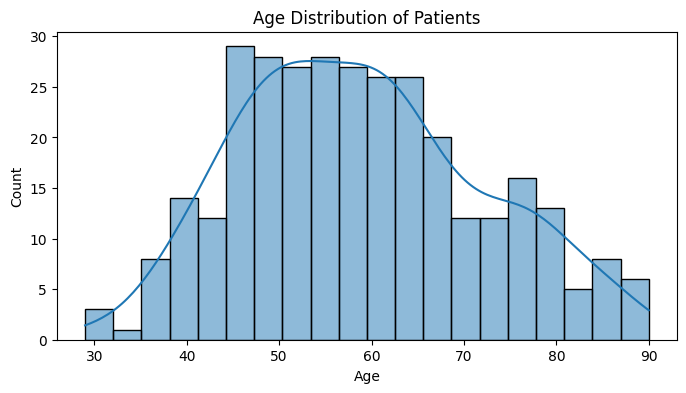

In [13]:
plt.figure(figsize=(8, 4))
sns.histplot(df['Age'], bins=20, kde=True)
plt.title('Age Distribution of Patients')
plt.show()

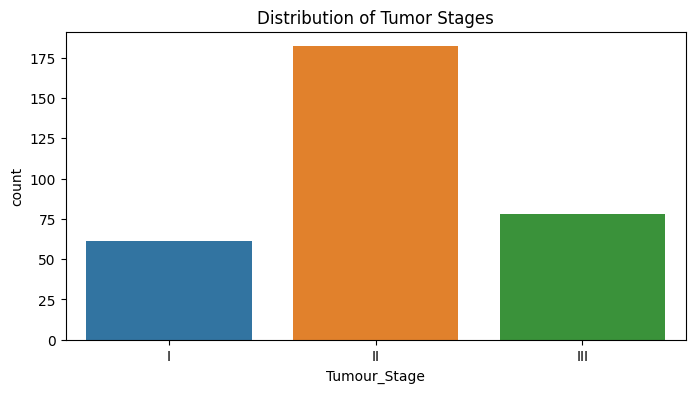

In [14]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='Tumour_Stage', order=['I', 'II', 'III'])
plt.title('Distribution of Tumor Stages')
plt.show()

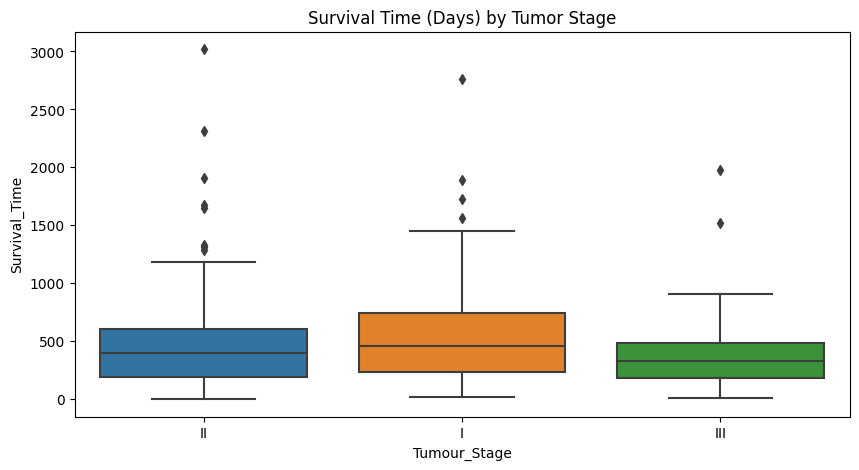

In [15]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='Tumour_Stage', y='Survival_Time')
plt.title('Survival Time (Days) by Tumor Stage')
plt.show()

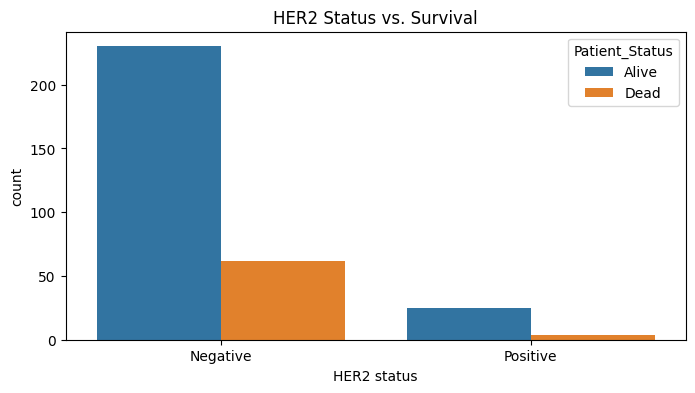

In [16]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='HER2 status', hue='Patient_Status')
plt.title('HER2 Status vs. Survival')
plt.show()

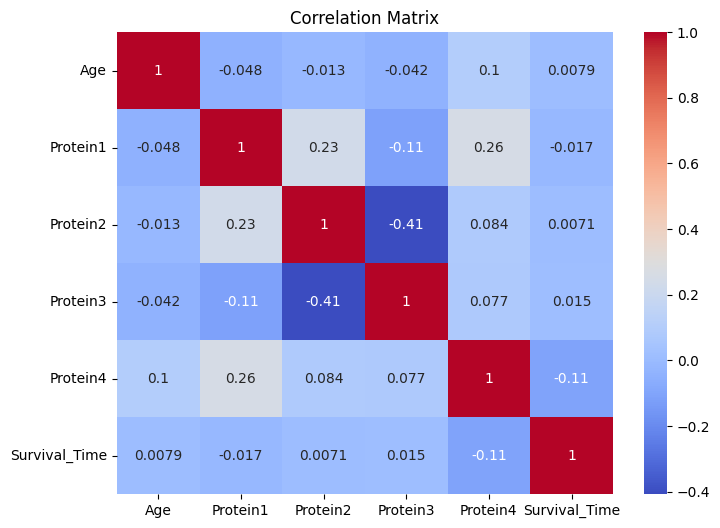

In [17]:
plt.figure(figsize=(8, 6))
corr = df[['Age', 'Protein1', 'Protein2', 'Protein3', 'Protein4', 'Survival_Time']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

**Weak correlations between proteins and survival time**

## Censoring Rate

In [18]:
censoring_rate = 1 - (df['Event_Observed'].sum() / len(df))
print(f"Censoring Rate: {censoring_rate:.2%}")

Censoring Rate: 79.44%


# Kaplan-Meier Survival Analysis

### Overall Survival Curve

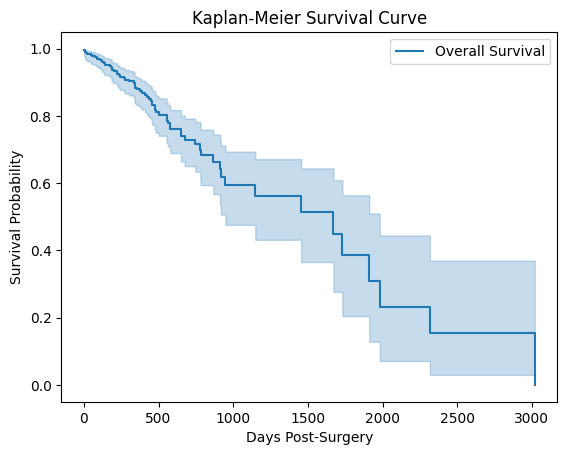

In [19]:
kmf = KaplanMeierFitter()
kmf.fit(df['Survival_Time'], event_observed=df['Event_Observed'])
kmf.plot_survival_function(label='Overall Survival')
plt.xlabel('Days Post-Surgery')
plt.ylabel('Survival Probability')
plt.title('Kaplan-Meier Survival Curve')
plt.show()

### Stratified Analysis by Tumor Stage

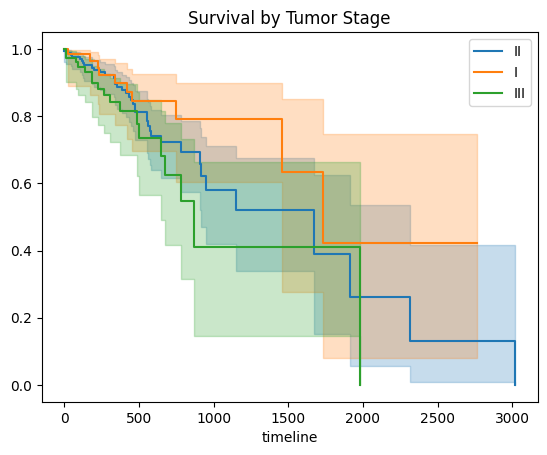

In [20]:
groups = df['Tumour_Stage']
for stage in groups.unique():
    mask = groups == stage
    kmf.fit(df[mask]['Survival_Time'], df[mask]['Event_Observed'], label=stage)
    kmf.plot_survival_function()

plt.title('Survival by Tumor Stage')
plt.show()

### Impact of Surgery Type

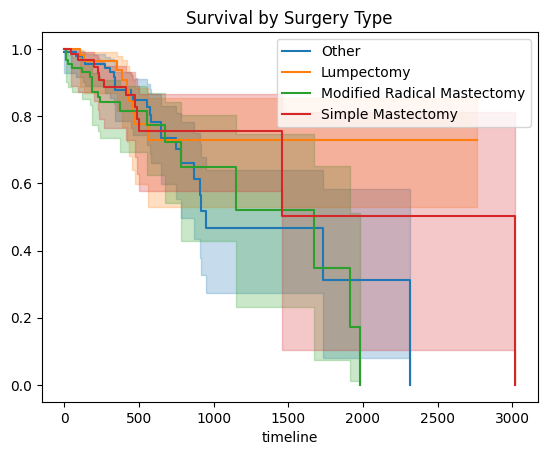

In [21]:
for surgery in df['Surgery_type'].unique():
    mask = df['Surgery_type'] == surgery
    kmf.fit(df[mask]['Survival_Time'], df[mask]['Event_Observed'], label=surgery)
    kmf.plot_survival_function()

plt.title('Survival by Surgery Type')
plt.show()

### Log-Rank Test for Significant Differences

In [22]:
group1 = df['Tumour_Stage'] == 'II'
group2 = df['Tumour_Stage'] == 'III'
results = logrank_test(df[group1]['Survival_Time'], df[group2]['Survival_Time'],
                       df[group1]['Event_Observed'], df[group2]['Event_Observed'])
print(f"p-value: {results.p_value:.4f}")

p-value: 0.1736


# **Conclusions**  

#### **1. Overall Survival (Kaplan-Meier Curve)**  
- The overall survival curve shows a gradual decline, with **cumulative survival at 50% around 1000 days (~2.7 years)**.  
- By **3000 days (~8.2 years)**, survival approaches **0%**, indicating most patients did not survive beyond this point in the study.  
- **Limitation**: The lack of follow-up beyond 3000 days suggests potential early study termination or censoring.  

#### **2. Survival by Tumor Stage**  
- **Stage III**: Demonstrates the **worst survival**, with a sharp decline within the first 500 days (~1.4 years), dropping to <20% survival by 1500 days (~4.1 years).  
- **Stages I and II**: Show **better prognosis**, maintaining >50% survival until 2000 days (~5.5 years).  
- **Interpretation**: Advanced tumor stages correlate with higher mortality risk, emphasizing the importance of early diagnosis.  

#### **3. Survival by Surgery Type**  
- **Modified Radical Mastectomy**: Best performance, with **~80% survival at 1500 days**.  
- **Lumpectomy** and **Other**: Intermediate survival (~50-60% at 1500 days).  
- **Simple Mastectomy**: Worst outcomes, with **<40% survival at 1500 days**.  
- **Key Note**: The **p-value of 0.1736** indicates **no statistically significant difference between surgery groups** in this sample, despite observed trends.  

#### **4. Censoring and Limitations**  
- **Censoring Rate: 79.44%** (high proportion of alive or lost-to-follow-up patients).  
  - Limits accuracy of long-term survival estimates.  
  - Suggests insufficient study duration or loss of follow-up.  